<a href="https://colab.research.google.com/github/Iamsdt/UdacityPyTorch/blob/master/src/notebook/PretrainedModel2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os

In [3]:
!wget -cq https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json

!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip

!unzip -qq flower_data.zip

replace flower_data/valid/61/image_06296.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [91]:
# create train and test loader
data_dir = 'flower_data'

from torchvision import datasets, transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to torch.FloatTensor
transform_train = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

transform_valid = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor()])

#data set
train_data = datasets.ImageFolder(data_dir + '/train', transform=transform_train)

valid_data = datasets.ImageFolder(data_dir + '/valid', transform=transform_valid)

test_data = datasets.ImageFolder(data_dir + '/valid', transform=test_transforms)

# obtain training indices that will be used for validation
num_train = len(train_data)
print(num_train)

6552


In [0]:
# index of num of train
indices = list(range(num_train))
#random the index
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
# divied into two part
train_idx, valid_idx = indices[split:], indices[:split]

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data,batch_size=batch_size,
    sampler = train_sampler,num_workers = num_workers)

valid_loader = torch.utils.data.DataLoader(
    valid_data,batch_size=batch_size,
    sampler = valid_sampler,num_workers = num_workers)

test_loader = torch.utils.data.DataLoader(
    test_data,batch_size=batch_size,num_workers = num_workers)

In [0]:
flowers_class = {"21": "fire lily", "3": "canterbury bells", "45": "bolero deep blue", "1": "pink primrose", "34": "mexican aster", "27": "prince of wales feathers", "7": "moon orchid", "16": "globe-flower", "25": "grape hyacinth", "26": "corn poppy", "79": "toad lily", "39": "siam tulip", "24": "red ginger", "67": "spring crocus", "35": "alpine sea holly", "32": "garden phlox", "10": "globe thistle", "6": "tiger lily", "93": "ball moss", "33": "love in the mist", "9": "monkshood", "102": "blackberry lily", "14": "spear thistle", "19": "balloon flower", "100": "blanket flower", "13": "king protea", "49": "oxeye daisy", "15": "yellow iris", "61": "cautleya spicata", "31": "carnation", "64": "silverbush", "68": "bearded iris", "63": "black-eyed susan", "69": "windflower", "62": "japanese anemone", "20": "giant white arum lily", "38": "great masterwort", "4": "sweet pea", "86": "tree mallow", "101": "trumpet creeper", "42": "daffodil", "22": "pincushion flower", "2": "hard-leaved pocket orchid", "54": "sunflower", "66": "osteospermum", "70": "tree poppy", "85": "desert-rose", "99": "bromelia", "87": "magnolia", "5": "english marigold", "92": "bee balm", "28": "stemless gentian", "97": "mallow", "57": "gaura", "40": "lenten rose", "47": "marigold", "59": "orange dahlia", "48": "buttercup", "55": "pelargonium", "36": "ruby-lipped cattleya", "91": "hippeastrum", "29": "artichoke", "71": "gazania", "90": "canna lily", "18": "peruvian lily", "98": "mexican petunia", "8": "bird of paradise", "30": "sweet william", "17": "purple coneflower", "52": "wild pansy", "84": "columbine", "12": "colt's foot", "11": "snapdragon", "96": "camellia", "23": "fritillary", "50": "common dandelion", "44": "poinsettia", "53": "primula", "72": "azalea", "65": "californian poppy", "80": "anthurium", "76": "morning glory", "37": "cape flower", "56": "bishop of llandaff", "60": "pink-yellow dahlia", "82": "clematis", "58": "geranium", "75": "thorn apple", "41": "barbeton daisy", "95": "bougainvillea", "43": "sword lily", "83": "hibiscus", "78": "lotus lotus", "88": "cyclamen", "94": "foxglove", "81": "frangipani", "74": "rose", "89": "watercress", "73": "water lily", "46": "wallflower", "77": "passion flower", "51": "petunia"}

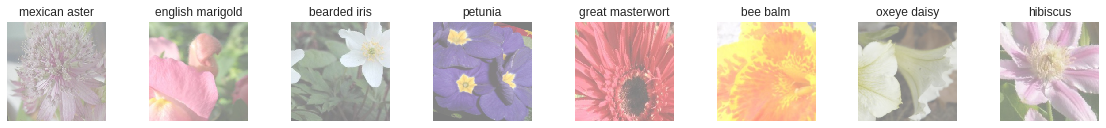

In [82]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(8):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    img = images[idx] / 2 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))
    #ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    # ax.set_title(str(labels[idx].item()))
    s = str(labels[idx].item())
    ax.set_title(flowers_class[s])

In [84]:
# load a pretrained model
model = models.densenet169(pretrained = True)

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [0]:
# Freeze the parameters
for param in model.parameters():
  param.required_grad = False

In [86]:
from collections import OrderedDict
from torch import nn
classifier = nn.Sequential(OrderedDict([
                ('fc1', nn.Linear(1024, 500)),
                ('relu', nn.ReLU()),
                ('fc2', nn.Linear(500, 102)),
                ('output', nn.LogSoftmax(dim=1))
                ]))

# replace the classifer
model.classifier = classifier
# check the classifier
print(model.classifier)

Sequential(
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=500, out_features=102, bias=True)
  (output): LogSoftmax()
)


In [89]:
from torch import optim
from torch.optim import lr_scheduler
# set cretrion and optimizer
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

#move tensor to default device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

RuntimeError: ignored

In [0]:
# Train
# number of epochs to train the model
n_epochs = 20

valid_loss_min = np.Inf

train_loss_data, valid_loss_data = [],[] 

for epoch in range(n_epochs):
  train_loss = 0
  test_loss = 0
  accuracy = 0
  
  ###############
  # Train Model #
  ###############
  model.train()
  # step scheduler
  scheduler.step()
  
  for images, labels in train_loader:
    # move to cuda
    images, labels = images.to(device), labels.to(device)
    #zero gradient
    optimizer.zero_grad()
    # Forward pass
    output = model(images)
    #calculate loss
    loss = criterion(output,labels)
    # backward pass
    loss.backward()
    # perform a single optimization step (parameters update)
    optimizer.step()
    # update train loss
    train_loss += loss.item() * images.size(0)
  
  
  ######################
  # Validate the model #
  ######################
  model.eval()
  for images, labels in valid_loader:
    # move to cuda
    images, labels = images.to(device), labels.to(device)
    # Forward pass
    log_ps = model(images)
    #calculate loss
    loss = criterion(log_ps,labels)
    # update train loss
    valid_loss += loss.item() * images.size(0)
    # calculate accuracy
    ps = torch.exp(log_ps)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    accuracy += torch.mean(equals.type(torch.FloatTensor))
  
  
  # Calculate the average loss in one epoch
  train_loss = train_loss/len(train_loader.dataset)
  valid_loss = valid_loss/len(valid_loader.dataset)
  # save the loss in an array
  train_loss_data.append(train_loss * 100)
  valid_loss_data.append(valid_loss * 100)
  
  # print the loss
  print("Epoch {}/{}".format(epoch+1,n_epochs),"\tTrain loss:{:.4f}".format(train_loss),
       "\t Valid Loss:{:.4f}".format(valid_loss),"\tAcceuracy:{:.2f}%".format(accuracy))
  
  # save the vodel
  if valid_loss <= valid_loss_min:
    print('Validation loss decreased ({:.4f} --> {:.4f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
    torch.save(model.state_dict(), 'model_cifar.pt')
    valid_loss_min = valid_loss

In [0]:
model.load_state_dict(torch.load("model_cifar.pt"))

In [0]:
# check for overfitting
plt.plot(train_loss_data, label = "taining loss")
plt.plot(valid_loss_data, label = "validation loss")
plt.legend(frameon = False)

In [0]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
  model.eval()
  # iterate over test data
  for data, target in test_loader:
      # move tensors to GPU if CUDA is available
      data, target = data.to(device), target.to(device)
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model(data)
      # calculate the batch loss
      loss = criterion(output, target)
      # update test loss 
      test_loss += loss.item()*data.size(0)
      # convert output probabilities to predicted class
      _, pred = torch.max(output, 1)    
      # compare predictions to true label
      correct = np.squeeze(pred.eq(target.data.view_as(pred)))
      # calculate test accuracy for each object class
      for i in range(batch_size):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))